In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [77]:
df = pd.read_csv('Hourly_Elec/PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [78]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.head()


,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [79]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

<AxesSubplot:xlabel='Datetime'>

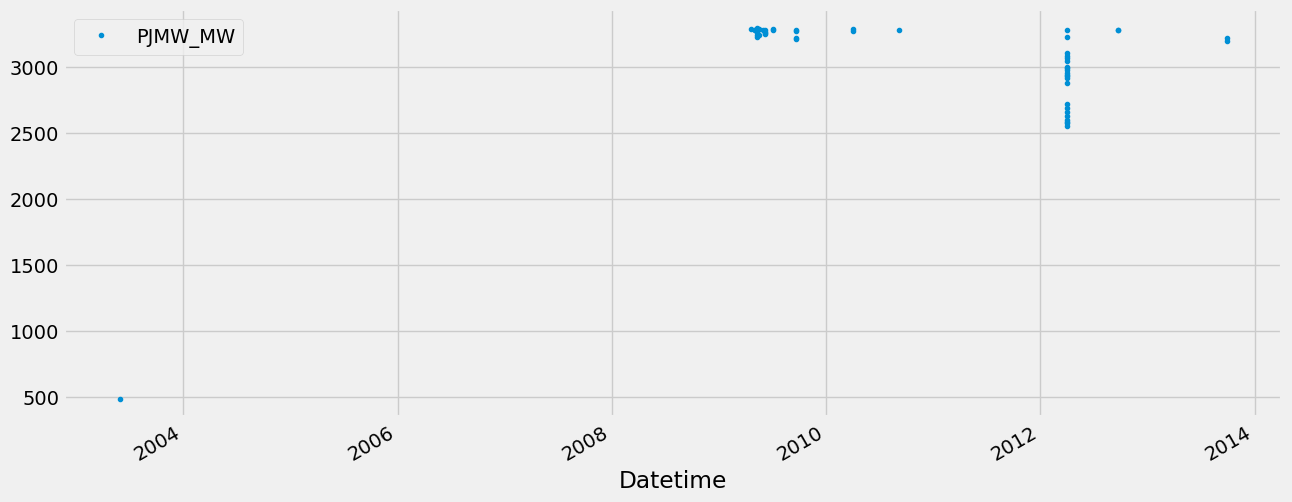

In [80]:
df.query('PJMW_MW < 3300').plot(figsize=(14, 6), style='.')

In [81]:
df = df.query('PJMW_MW > 3300').copy()

In [84]:
### Make a definition for adding time features
def add_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['day_of_year'] = df.index.dayofyear
    return df
df = add_features(df)
df.head()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year
Datetime,,,,,,,,,,,,,,
2002-12-31 01:00:00,5077.0,31,12,1,1,365,NaN,NaN,NaN,4,2002,31,1,365
2002-12-31 02:00:00,4939.0,31,12,1,2,365,NaN,NaN,NaN,4,2002,31,1,365
2002-12-31 03:00:00,4885.0,31,12,1,3,365,NaN,NaN,NaN,4,2002,31,1,365
2002-12-31 04:00:00,4857.0,31,12,1,4,365,NaN,NaN,NaN,4,2002,31,1,365
2002-12-31 05:00:00,4930.0,31,12,1,5,365,NaN,NaN,NaN,4,2002,31,1,365


In [85]:
### Make a definition for adding lag times(yearly basis)
dict_df = df.to_dict()
# dict_df
def lag_times_year(df):
    df['time_lag_1_year'] = (df.index - pd.Timedelta(365, unit='d')).map(dict_df['PJMW_MW'])
    df['time_lag_2_year'] = (df.index - pd.Timedelta(365*2, unit='d')).map(dict_df['PJMW_MW'])
    df['time_lag_3_year'] = (df.index - pd.Timedelta(365*3, unit='d')).map(dict_df['PJMW_MW'])
    return df
df = lag_times_year(df)
df.tail()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year
Datetime,,,,,,,,,,,,,,
2018-01-01 20:00:00,8401.0,1,1,0,20,1,5690.0,6127.0,6672.0,1,2018,1,1,1
2018-01-01 21:00:00,8373.0,1,1,0,21,1,5668.0,6110.0,6617.0,1,2018,1,1,1
2018-01-01 22:00:00,8238.0,1,1,0,22,1,5543.0,6010.0,6520.0,1,2018,1,1,1
2018-01-01 23:00:00,7958.0,1,1,0,23,1,5311.0,5794.0,6264.0,1,2018,1,1,1
2018-01-02 00:00:00,7691.0,2,1,1,0,2,5021.0,5593.0,6009.0,1,2018,2,1,2


In [86]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

### Make a definition for splitting data
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()
df.head()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year
Datetime,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,1,4,0,1,91,NaN,NaN,NaN,2,2002,1,14,91
2002-04-01 02:00:00,4306.0,1,4,0,2,91,NaN,NaN,NaN,2,2002,1,14,91
2002-04-01 03:00:00,4322.0,1,4,0,3,91,NaN,NaN,NaN,2,2002,1,14,91
2002-04-01 04:00:00,4359.0,1,4,0,4,91,NaN,NaN,NaN,2,2002,1,14,91
2002-04-01 05:00:00,4436.0,1,4,0,5,91,NaN,NaN,NaN,2,2002,1,14,91


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143154 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PJMW_MW                143154 non-null  float64
 1   date                   143154 non-null  int32  
 2   month                  143154 non-null  int32  
 3   day_of_week            143154 non-null  int32  
 4   hour                   143154 non-null  int32  
 5   day_of_month_per_year  143154 non-null  int32  
 6   time_lag_1_year        134315 non-null  float64
 7   time_lag_2_year        125559 non-null  float64
 8   time_lag_3_year        116802 non-null  float64
 9   quarter                143154 non-null  int32  
 10  year                   143154 non-null  int32  
 11  day_of_month           143154 non-null  int32  
 12  week_of_year           143154 non-null  UInt32 
 13  day_of_year            143154 non-null  int32  
dtypes:

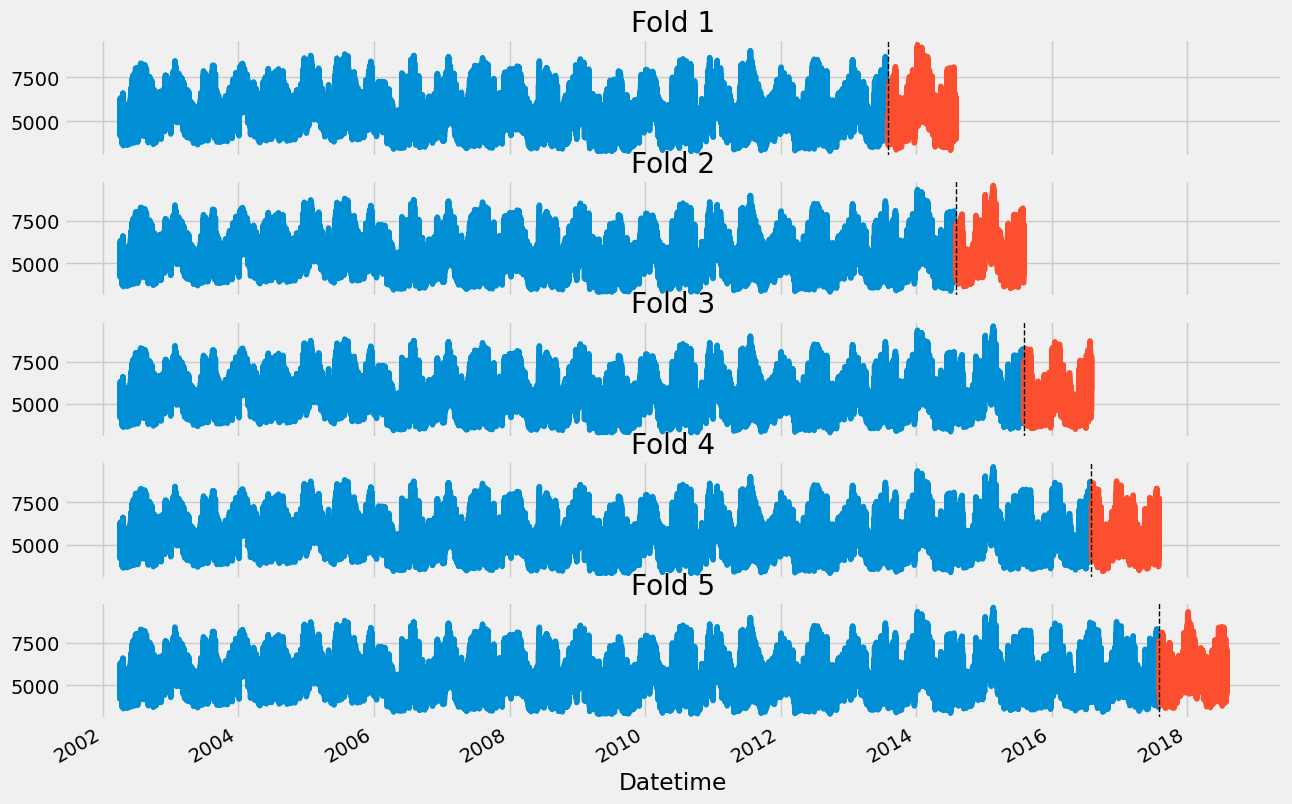

In [88]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10),
                              sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['PJMW_MW'].plot(ax=axes[fold], title='Fold {}'.format(fold+1))
    val['PJMW_MW'].plot(ax=axes[fold], label='validation')
    axes[fold].axvline(train.index.max(), color='black', linestyle='--', lw=1)
    fold += 1

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143154 entries, 2002-04-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PJMW_MW                143154 non-null  float64
 1   date                   143154 non-null  int32  
 2   month                  143154 non-null  int32  
 3   day_of_week            143154 non-null  int32  
 4   hour                   143154 non-null  int32  
 5   day_of_month_per_year  143154 non-null  int32  
 6   time_lag_1_year        134315 non-null  float64
 7   time_lag_2_year        125559 non-null  float64
 8   time_lag_3_year        116802 non-null  float64
 9   quarter                143154 non-null  int32  
 10  year                   143154 non-null  int32  
 11  day_of_month           143154 non-null  int32  
 12  week_of_year           143154 non-null  UInt32 
 13  day_of_year            143154 non-null  int32  
dtypes:

In [92]:
FEATURES = ['hour', 'day_of_week', 'month', 'quarter', 'year',
            'day_of_month', 'day_of_year',
            'time_lag_1_year', 'time_lag_2_year', 'time_lag_3_year']
TARGET = 'PJMW_MW'

preds = []
scores = []
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_val, y_val = val[FEATURES], val[TARGET]

    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              early_stopping_rounds=50, verbose=100)
    pred = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, pred))
    preds.append(pred)
    scores.append(score)
    
    fold += 1

[0]	validation_0-rmse:5401.81363	validation_1-rmse:5470.37700


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:414.83298	validation_1-rmse:642.64510
[173]	validation_0-rmse:372.66594	validation_1-rmse:644.29176
[0]	validation_0-rmse:5406.63641	validation_1-rmse:5543.84887


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:427.79677	validation_1-rmse:605.51182
[200]	validation_0-rmse:373.19515	validation_1-rmse:603.23109
[207]	validation_0-rmse:370.55657	validation_1-rmse:602.86534
[0]	validation_0-rmse:5416.03195	validation_1-rmse:5246.99318


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:436.66593	validation_1-rmse:667.71409
[108]	validation_0-rmse:429.23369	validation_1-rmse:674.90125
[0]	validation_0-rmse:5404.81603	validation_1-rmse:5334.40472


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:443.94549	validation_1-rmse:666.15385
[188]	validation_0-rmse:397.61783	validation_1-rmse:666.09097
[0]	validation_0-rmse:5400.30347	validation_1-rmse:5510.89219


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:456.06132	validation_1-rmse:718.26968
[165]	validation_0-rmse:416.15438	validation_1-rmse:727.08797


In [93]:
print('Mean score: ', np.mean(scores))
print(scores)

Mean score:  641.8773546976731
[635.1838716720866, 598.4295847674442, 604.7094831245967, 655.8002538917851, 715.2635800324528]


### Prediction the future

In [102]:
predict_from_here = df.index.max()

In [103]:
new_rgr = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
new_rgr.fit(df[FEATURES], df[TARGET],
            eval_set=[(df[FEATURES], df[TARGET])],
            early_stopping_rounds=50, verbose=100)

[0]	validation_0-rmse:5406.64293


/Users/jacob/opt/anaconda3/envs/SIADS/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:464.53520
[200]	validation_0-rmse:409.57618
[300]	validation_0-rmse:378.14857
[400]	validation_0-rmse:356.01580
[500]	validation_0-rmse:336.71307
[600]	validation_0-rmse:322.36160
[700]	validation_0-rmse:309.25432
[800]	validation_0-rmse:298.57384
[900]	validation_0-rmse:287.50766
[999]	validation_0-rmse:278.73475


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [99]:
future_range = pd.date_range('2018-08-03 00:00:00', '2019-08-03 00:00:00', freq='H')
future_df = pd.DataFrame(index=future_range)
future_df['isFuture'] = True
df['isFuture'] = False
# future_df.head()
df_and_future = pd.concat([df, future_df])
df_and_future.tail()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year,isFuture
2019-08-02 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,True
2019-08-02 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,True
2019-08-02 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,True
2019-08-02 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,True
2019-08-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,True


In [101]:
df_and_future = add_features(df_and_future)
df_and_future = lag_times_year(df_and_future)
df_and_future.tail()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year,isFuture
2019-08-02 20:00:00,NaN,NaN,8,4,20,NaN,6545.0,7240.0,7468.0,3,2019,2,31,214,True
2019-08-02 21:00:00,NaN,NaN,8,4,21,NaN,6496.0,6970.0,7186.0,3,2019,2,31,214,True
2019-08-02 22:00:00,NaN,NaN,8,4,22,NaN,6325.0,6697.0,6889.0,3,2019,2,31,214,True
2019-08-02 23:00:00,NaN,NaN,8,4,23,NaN,5892.0,6250.0,6422.0,3,2019,2,31,214,True
2019-08-03 00:00:00,NaN,NaN,8,5,0,NaN,5489.0,5591.0,5780.0,3,2019,3,31,215,True


In [104]:
future_w_features = df_and_future.query('isFuture == True').copy()
future_w_features.head()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year,isFuture
2018-08-03 00:00:00,NaN,NaN,8,4,0,NaN,5591.0,5780.0,5472.0,3,2018,3,31,215,True
2018-08-03 01:00:00,NaN,NaN,8,4,1,NaN,5170.0,5348.0,5066.0,3,2018,3,31,215,True
2018-08-03 02:00:00,NaN,NaN,8,4,2,NaN,4948.0,5091.0,4766.0,3,2018,3,31,215,True
2018-08-03 03:00:00,NaN,NaN,8,4,3,NaN,4700.0,4878.0,4570.0,3,2018,3,31,215,True
2018-08-03 04:00:00,NaN,NaN,8,4,4,NaN,4606.0,4765.0,4466.0,3,2018,3,31,215,True


In [105]:
future_w_features['pred'] = new_rgr.predict(future_w_features[FEATURES])
future_w_features.head()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year,isFuture,pred
2018-08-03 00:00:00,NaN,NaN,8,4,0,NaN,5591.0,5780.0,5472.0,3,2018,3,31,215,True,5455.458008
2018-08-03 01:00:00,NaN,NaN,8,4,1,NaN,5170.0,5348.0,5066.0,3,2018,3,31,215,True,4998.555176
2018-08-03 02:00:00,NaN,NaN,8,4,2,NaN,4948.0,5091.0,4766.0,3,2018,3,31,215,True,4762.665527
2018-08-03 03:00:00,NaN,NaN,8,4,3,NaN,4700.0,4878.0,4570.0,3,2018,3,31,215,True,4593.896484
2018-08-03 04:00:00,NaN,NaN,8,4,4,NaN,4606.0,4765.0,4466.0,3,2018,3,31,215,True,4548.043945


<AxesSubplot:>

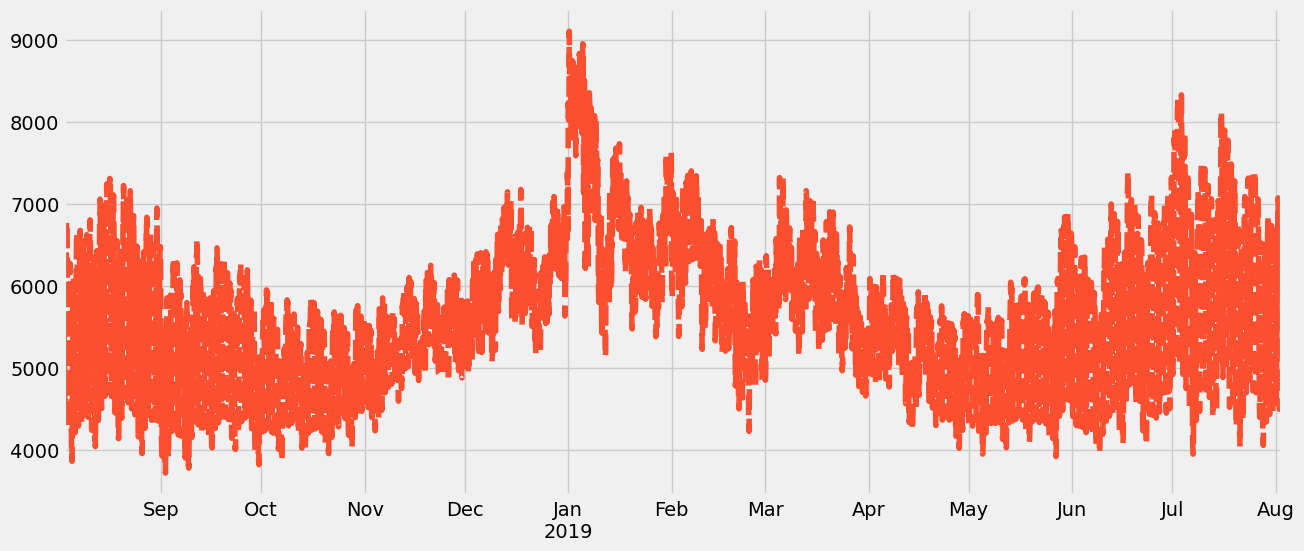

In [108]:
future_w_features['pred'].plot(figsize=(14, 6), style='--', color=sns.color_palette()[1])

In [110]:
# df의 PJMW_MW와 future_w_features의 pred를 한 열로 만들어 새로운 데이터 프레임을 생성한다.
df_and_future['forecast'] = pd.concat([df['PJMW_MW'], future_w_features['pred']])
df_and_future.tail()

,PJMW_MW,date,month,day_of_week,hour,day_of_month_per_year,time_lag_1_year,time_lag_2_year,time_lag_3_year,quarter,year,day_of_month,week_of_year,day_of_year,isFuture,forecast
2019-08-02 20:00:00,NaN,NaN,8,4,20,NaN,6545.0,7240.0,7468.0,3,2019,2,31,214,True,6389.241211
2019-08-02 21:00:00,NaN,NaN,8,4,21,NaN,6496.0,6970.0,7186.0,3,2019,2,31,214,True,6305.082031
2019-08-02 22:00:00,NaN,NaN,8,4,22,NaN,6325.0,6697.0,6889.0,3,2019,2,31,214,True,5969.553223
2019-08-02 23:00:00,NaN,NaN,8,4,23,NaN,5892.0,6250.0,6422.0,3,2019,2,31,214,True,5623.061035
2019-08-03 00:00:00,NaN,NaN,8,5,0,NaN,5489.0,5591.0,5780.0,3,2019,3,31,215,True,5172.508789


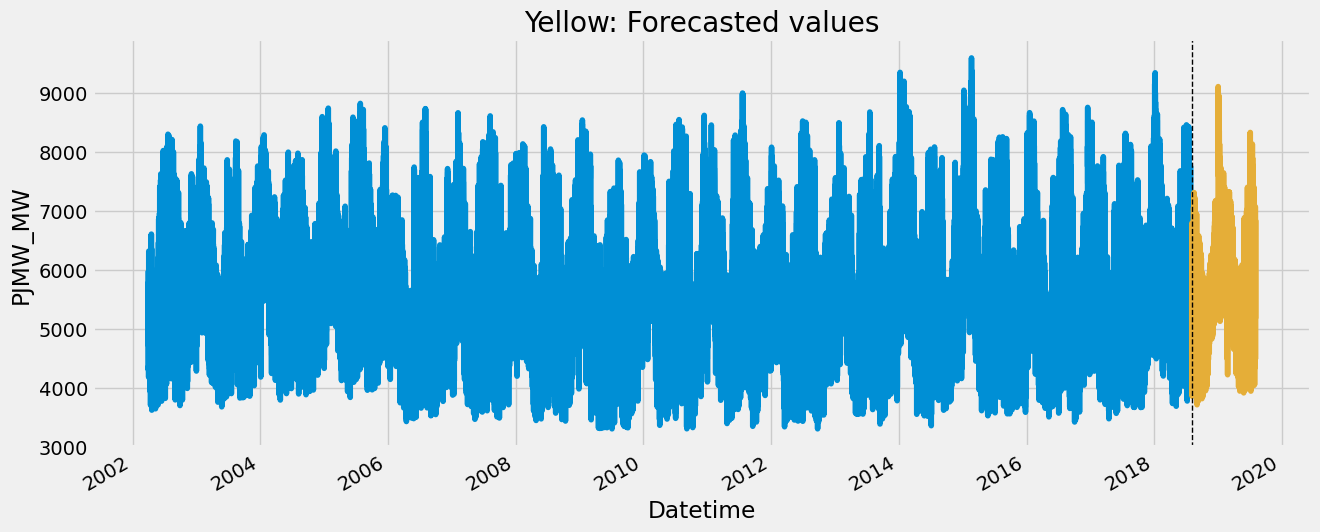

In [115]:
# df_and_future의 forecast 열을 시각화한다.
# predict_from_here 전후로 색깔을 다르게 지정한다.
fig, ax = plt.subplots(figsize=(14, 6))
df_and_future['forecast'][:predict_from_here].plot(ax=ax, color=sns.color_palette()[0])
df_and_future['forecast'][predict_from_here:].plot(ax=ax, color=sns.color_palette()[2])
ax.axvline(predict_from_here, color='black', linestyle='--', lw=1)
ax.set_title('Yellow: Forecasted values')
ax.set_ylabel('PJMW_MW')
ax.set_xlabel('Datetime')
plt.show()